<a href="https://colab.research.google.com/github/Akshaypakhle10/ML/blob/master/logistic_model_for_covid_track_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [0]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df_ = pd.read_csv(url)
df = df_.drop(['Lat','Long'],axis=1).set_index(['Country/Region','Province/State']).T

In [0]:
def preprocess(country,province):
    y = np.array(df[country][province])
    y = y.astype(np.float32)
    x = np.array(range(len(y)))
    return x,y

def process_country(country):
    val_error_dict = dict()
    curves_dict = dict()
    keys = []
    for province in df[country].columns:
        keys.append(province)
        x,y = preprocess(country,province)
        (a,b,peak),val_error = optimal_logistic(x,y)
        f = lambda x_: logistic(x_,a,b,peak)
        val_error_dict[province] = val_error
        curves_dict[province] = f
    return val_error_dict,curves_dict,keys

def predict(country,province):
    x,y = preprocess(country,province)
    (a,b,peak),val_error = optimal_logistic(x,y)
    f = lambda x_: logistic(x_,a,b,peak)
    return f(x[-1]),val_error

In [0]:
#Luke Beasley's get_inflection() function


def before_sign(x):
    if x <0:
        return -1
    if x>0:
        return 1
    else:
        return 0
def after_sign(x):
    if x >0:
        return -1
    if x<0:
        return 1
    else:
        return 0

before_vect = np.vectorize(before_sign)
after_vect = np.vectorize(after_sign)




def get_inflection(case_der, window_size = 20):
    inflection_point = 0
    max_val = 0
    for idx, val in enumerate(case_der):
        if idx ==0:
            continue
        if idx == len(case_der)-1:
            continue
        if idx <window_size:
            if np.sum(before_vect(case_der[0:idx])) + np.sum(after_vect(case_der[idx+1:idx+1+window_size]))> max_val:
                inflection_point = idx
                max_val = np.sum(before_vect(case_der[0:idx])) + np.sum(after_vect(case_der[idx+1:idx+1+window_size]))
        if idx >= window_size and idx < len(case_der)-window_size:
            if np.sum(before_vect(case_der[idx-window_size:idx])) + np.sum(after_vect(case_der[idx+1:idx+1+window_size]))> max_val:
                inflection_point = idx
                max_val = np.sum(before_vect(case_der[idx-window_size:idx])) + np.sum(after_vect(case_der[idx+1:idx+1+window_size]))
        if idx >=window_size and idx >= len(case_der)-window_size:
            if np.sum(before_vect(case_der[idx-window_size:idx])) + np.sum(after_vect(case_der[idx+1:]))> max_val:
                inflection_point = idx
                max_val = np.sum(before_vect(case_der[idx-window_size:idx])) + np.sum(after_vect(case_der[idx+1:]))
    return inflection_point

In [0]:
def logistic(x, a, b,c):
    return a / (1. + np.exp(-1.0/b * (x - c)))

def get_peak(y):
    inf = get_inflection(np.diff(y,2))
    return list(range(inf-15,inf+15))
    #return [75,76,77,78,79,80,81,82,83]

def optimal_logistic(x,y):
    y_train = y[:-7]
    x_train = x[:-7]
    min_error,opt_p = float('inf'),[0,0,0]
    try:
      p0,_ = opt.curve_fit(logistic,x_train,y_train) #initial values to try
    except:
      try:
          p0,_ = opt.curve_fit(logistic,x,y) #initial values to try
      except:
          p0 = (1000,7,80)
    peaks = get_peak(y_train) #candidate times for peak infection rate
    for peak in peaks:
        fixed_peak_logistic = lambda x_,a,b: logistic(x_,a,b,peak)
        (a,b),_ = opt.curve_fit(fixed_peak_logistic,x_train,y_train,p0=[p0[0],p0[1]])
        opt_logistic = lambda x_: logistic(x_,a,b,peak)
        error = abs(opt_logistic(x_train[-1])-y_train[-1])/y_train[-1] 
        if error < min_error:
            min_error,opt_p = error,[a,b,peak]
    val_error = abs(logistic(x[-1],*opt_p)-y[-1])/y[-1] #error on the last available day from validation set
    return opt_p,val_error
            

In [0]:
#example use:

val_dict,pred_dict,provinces = process_country('Australia')
val_dict

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


{'Australian Capital Territory': 0.7606216447689261,
 'New South Wales': 0.0004897599958189368,
 'Northern Territory': 0.005811091225093331,
 'Queensland': 0.0010680507951041519,
 'South Australia': 0.017609944229545756,
 'Tasmania': 0.8675991451928229,
 'Victoria': 0.00956140171303077,
 'Western Australia': 0.02593814246635857}

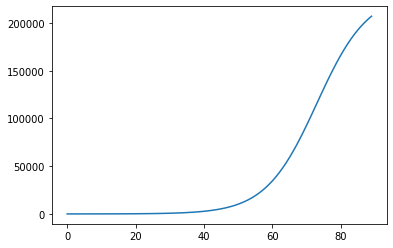

In [0]:
for province in provinces:
  plt.plot([pred_dict[province](x) for x in range(90)])

In [0]:
preds = {}
val_errors = {}
for (country,province) in df.columns:
    if province == 'Recovered':
      continue
    pred,error = predict(country,province)
    preds[(country,province)] = pred
    val_errors[(country,province)] = error

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


In [0]:
total = sum([preds[x] for x in preds])
total

2276421.937166573

In [0]:
s = sorted(val_errors,key=lambda x:-val_errors[x])
sorted_val_errors = [(region,val_errors[region]) for region in s]

In [0]:
sorted_val_errors

[(('Canada', 'Diamond Princess'), inf),
 (('Sao Tome and Principe', nan), 1.0000000000021814),
 (('Bangladesh', nan), 0.9781803123455709),
 (('Djibouti', nan), 0.964102079184423),
 (('Guinea', nan), 0.9547159111895858),
 (('Nigeria', nan), 0.9356849909294688),
 (('Jamaica', nan), 0.9326305308333548),
 (('Ghana', nan), 0.9275321418502611),
 (('Bolivia', nan), 0.9245095758817946),
 (("Cote d'Ivoire", nan), 0.9100574431730464),
 (('Kyrgyzstan', nan), 0.9077322799775477),
 (('Canada', 'Nova Scotia'), 0.906414329788729),
 (('Kosovo', nan), 0.9040355663580947),
 (('Singapore', nan), 0.9020840163721872),
 (('Niger', nan), 0.900408968080743),
 (('Kenya', nan), 0.8872093016972247),
 (('Congo (Kinshasa)', nan), 0.8859724870854334),
 (('France', 'Mayotte'), 0.883506918913314),
 (('United Kingdom', 'Isle of Man'), 0.8802742206864939),
 (('Georgia', nan), 0.8693844041452791),
 (('Australia', 'Tasmania'), 0.8675991451928229),
 (('Senegal', nan), 0.8665825115349673),
 (('West Bank and Gaza', nan), 0.